<a href="https://colab.research.google.com/github/juooo1117/practice_AI_Learning/blob/main/classify_text_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify text with BERT

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -U "tensorflow-text==2.13.*"

In [ ]:
!pip install "tf-models-official==2.13.*"

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

### Download the IMDB dataset


In [4]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 5s 0us/step


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size,
                                                                           validation_split=0.2,
                                                                           subset='training',
                                                                           seed=seed)
class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/train', batch_size=batch_size,
                                                                     validation_split=0.2,
                                                                     subset='validation',
                                                                     seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory('aclImdb/test', batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [6]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

## Loading models from TensorFlow Hub

In [7]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


## Using the BERT model

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.762629    0.99280983 -0.18611868  0.36673862  0.15233733  0.6550447
  0.9681154  -0.9486271   0.00216128 -0.9877732   0.06842692 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946346  0.3432128   0.33231518 ...  0.21300825  0.7102068
  -0.05771117]
 [-0.28742072  0.31981036 -0.23018576 ...  0.58455    -0.21329743
   0.72692114]
 [-0.66157067  0.68876773 -0.8743301  ...  0.1087725  -0.26173177
   0.47855407]
 ...
 [-0.2256118  -0.2892561  -0.0706445  ...  0.47566038  0.83277136
   0.40025333]
 [-0.2982428  -0.27473134 -0.05450517 ...  0.48849747  1.0955354
   0.18163396]
 [-0.44378242  0.00930811  0.07223688 ...  0.1729009   1.1833243
   0.07898017]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define model


In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

  return tf.keras.Model(text_input, net)

In [13]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6822799]], shape=(1, 1), dtype=float32)


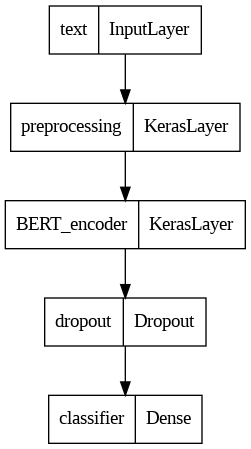

In [14]:
# model's structure
tf.keras.utils.plot_model(classifier_model)

## Model training

In [15]:
# binary classification problem
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [16]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

In [17]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

### Evaluate the model

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

  1/782 [..............................] - ETA: 3:48 - loss: 0.5644 - binary_accuracy: 0.8438

  2/782 [..............................] - ETA: 3:40 - loss: 0.5092 - binary_accuracy: 0.8594

  3/782 [..............................] - ETA: 3:36 - loss: 0.4155 - binary_accuracy: 0.8750

  4/782 [..............................] - ETA: 3:41 - loss: 0.3583 - binary_accuracy: 0.8828

  5/782 [..............................] - ETA: 3:39 - loss: 0.3707 - binary_accuracy: 0.8813

  6/782 [..............................] - ETA: 3:38 - loss: 0.4020 - binary_accuracy: 0.8802

  7/782 [..............................] - ETA: 3:39 - loss: 0.3965 - binary_accuracy: 0.8795

  8/782 [..............................] - ETA: 3:38 - loss: 0.3718 - binary_accuracy: 0.8867

  9/782 [..............................] - ETA: 3:39 - loss: 0.3623 - binary_accuracy: 0.8924

 10/782 [..............................] - ETA: 3:40 - loss: 0.3873 - binary_accuracy: 0.8844

 11/782 [..............................] - ETA: 3:40 - loss: 0.4029 - binary_accuracy: 0.8722

 12/782 [..............................] - ETA: 3:40 - loss: 0.4351 - binary_accuracy: 0.8672

 13/782 [..............................] - ETA: 3:39 - loss: 0.4307 - binary_accuracy: 0.8630

 14/782 [..............................] - ETA: 3:39 - loss: 0.4062 - binary_accuracy: 0.8705

 15/782 [..............................] - ETA: 3:39 - loss: 0.4182 - binary_accuracy: 0.8667

 16/782 [..............................] - ETA: 3:39 - loss: 0.4259 - binary_accuracy: 0.8672

 17/782 [..............................] - ETA: 3:38 - loss: 0.4049 - binary_accuracy: 0.8713

 18/782 [..............................] - ETA: 3:37 - loss: 0.4059 - binary_accuracy: 0.8733

 19/782 [..............................] - ETA: 3:37 - loss: 0.4009 - binary_accuracy: 0.8750

 20/782 [..............................] - ETA: 3:36 - loss: 0.4051 - binary_accuracy: 0.8766

 21/782 [..............................] - ETA: 3:36 - loss: 0.3896 - binary_accuracy: 0.8810

 22/782 [..............................] - ETA: 3:35 - loss: 0.3873 - binary_accuracy: 0.8821

 23/782 [..............................] - ETA: 3:35 - loss: 0.3760 - binary_accuracy: 0.8845

 24/782 [..............................] - ETA: 3:35 - loss: 0.3646 - binary_accuracy: 0.8867

 25/782 [..............................] - ETA: 3:34 - loss: 0.3629 - binary_accuracy: 0.8875

 26/782 [..............................] - ETA: 3:35 - loss: 0.3669 - binary_accuracy: 0.8858

 27/782 [>.............................] - ETA: 3:34 - loss: 0.3598 - binary_accuracy: 0.8877

 28/782 [>.............................] - ETA: 3:34 - loss: 0.3595 - binary_accuracy: 0.8873

 29/782 [>.............................] - ETA: 3:34 - loss: 0.3681 - binary_accuracy: 0.8804

 30/782 [>.............................] - ETA: 3:34 - loss: 0.3744 - binary_accuracy: 0.8781

 31/782 [>.............................] - ETA: 3:33 - loss: 0.3761 - binary_accuracy: 0.8770

 32/782 [>.............................] - ETA: 3:33 - loss: 0.3856 - binary_accuracy: 0.8760

 33/782 [>.............................] - ETA: 3:33 - loss: 0.4005 - binary_accuracy: 0.8731

 34/782 [>.............................] - ETA: 3:33 - loss: 0.4023 - binary_accuracy: 0.8722

 35/782 [>.............................] - ETA: 3:32 - loss: 0.4066 - binary_accuracy: 0.8714

 36/782 [>.............................] - ETA: 3:32 - loss: 0.4162 - binary_accuracy: 0.8689

 37/782 [>.............................] - ETA: 3:32 - loss: 0.4108 - binary_accuracy: 0.8699

 38/782 [>.............................] - ETA: 3:32 - loss: 0.4093 - binary_accuracy: 0.8709

 39/782 [>.............................] - ETA: 3:31 - loss: 0.4110 - binary_accuracy: 0.8702

 40/782 [>.............................] - ETA: 3:31 - loss: 0.4172 - binary_accuracy: 0.8680

 41/782 [>.............................] - ETA: 3:30 - loss: 0.4220 - binary_accuracy: 0.8659

 42/782 [>.............................] - ETA: 3:30 - loss: 0.4221 - binary_accuracy: 0.8661

 43/782 [>.............................] - ETA: 3:30 - loss: 0.4231 - binary_accuracy: 0.8656

 44/782 [>.............................] - ETA: 3:29 - loss: 0.4270 - binary_accuracy: 0.8643

 45/782 [>.............................] - ETA: 3:29 - loss: 0.4289 - binary_accuracy: 0.8632

 46/782 [>.............................] - ETA: 3:29 - loss: 0.4310 - binary_accuracy: 0.8621

 47/782 [>.............................] - ETA: 3:28 - loss: 0.4297 - binary_accuracy: 0.8610

 48/782 [>.............................] - ETA: 3:28 - loss: 0.4223 - binary_accuracy: 0.8633

 49/782 [>.............................] - ETA: 3:27 - loss: 0.4218 - binary_accuracy: 0.8629

 50/782 [>.............................] - ETA: 3:27 - loss: 0.4248 - binary_accuracy: 0.8625

 51/782 [>.............................] - ETA: 3:27 - loss: 0.4221 - binary_accuracy: 0.8634

 52/782 [>.............................] - ETA: 3:27 - loss: 0.4196 - binary_accuracy: 0.8648

 53/782 [=>............................] - ETA: 3:26 - loss: 0.4204 - binary_accuracy: 0.8656

 54/782 [=>............................] - ETA: 3:26 - loss: 0.4178 - binary_accuracy: 0.8663

 55/782 [=>............................] - ETA: 3:26 - loss: 0.4203 - binary_accuracy: 0.8659

 56/782 [=>............................] - ETA: 3:25 - loss: 0.4165 - binary_accuracy: 0.8672

 57/782 [=>............................] - ETA: 3:25 - loss: 0.4178 - binary_accuracy: 0.8662

 58/782 [=>............................] - ETA: 3:24 - loss: 0.4207 - binary_accuracy: 0.8648

 59/782 [=>............................] - ETA: 3:24 - loss: 0.4239 - binary_accuracy: 0.8633

 60/782 [=>............................] - ETA: 3:24 - loss: 0.4188 - binary_accuracy: 0.8646

 61/782 [=>............................] - ETA: 3:24 - loss: 0.4198 - binary_accuracy: 0.8648

 62/782 [=>............................] - ETA: 3:24 - loss: 0.4214 - binary_accuracy: 0.8639

 63/782 [=>............................] - ETA: 3:23 - loss: 0.4189 - binary_accuracy: 0.8646

 64/782 [=>............................] - ETA: 3:23 - loss: 0.4255 - binary_accuracy: 0.8638

 65/782 [=>............................] - ETA: 3:23 - loss: 0.4223 - binary_accuracy: 0.8644

 66/782 [=>............................] - ETA: 3:22 - loss: 0.4211 - binary_accuracy: 0.8646

 67/782 [=>............................] - ETA: 3:22 - loss: 0.4184 - binary_accuracy: 0.8652

 68/782 [=>............................] - ETA: 3:22 - loss: 0.4176 - binary_accuracy: 0.8649

 69/782 [=>............................] - ETA: 3:21 - loss: 0.4154 - binary_accuracy: 0.8646

 70/782 [=>............................] - ETA: 3:21 - loss: 0.4117 - binary_accuracy: 0.8656

 71/782 [=>............................] - ETA: 3:21 - loss: 0.4087 - binary_accuracy: 0.8666

 72/782 [=>............................] - ETA: 3:20 - loss: 0.4068 - binary_accuracy: 0.8676

 73/782 [=>............................] - ETA: 3:20 - loss: 0.4094 - binary_accuracy: 0.8664

 74/782 [=>............................] - ETA: 3:19 - loss: 0.4064 - binary_accuracy: 0.8674

 75/782 [=>............................] - ETA: 3:19 - loss: 0.4056 - binary_accuracy: 0.8675

 76/782 [=>............................] - ETA: 3:19 - loss: 0.4101 - binary_accuracy: 0.8668

 77/782 [=>............................] - ETA: 3:18 - loss: 0.4053 - binary_accuracy: 0.8685

 78/782 [=>............................] - ETA: 3:18 - loss: 0.4015 - binary_accuracy: 0.8694

 79/782 [==>...........................] - ETA: 3:18 - loss: 0.4039 - binary_accuracy: 0.8679

 80/782 [==>...........................] - ETA: 3:17 - loss: 0.4085 - binary_accuracy: 0.8672

 81/782 [==>...........................] - ETA: 3:17 - loss: 0.4065 - binary_accuracy: 0.8681

 82/782 [==>...........................] - ETA: 3:17 - loss: 0.4052 - binary_accuracy: 0.8685

 83/782 [==>...........................] - ETA: 3:16 - loss: 0.4023 - binary_accuracy: 0.8690

 84/782 [==>...........................] - ETA: 3:16 - loss: 0.4045 - binary_accuracy: 0.8676

 85/782 [==>...........................] - ETA: 3:16 - loss: 0.4037 - binary_accuracy: 0.8680

 86/782 [==>...........................] - ETA: 3:15 - loss: 0.4022 - binary_accuracy: 0.8685

 87/782 [==>...........................] - ETA: 3:15 - loss: 0.4032 - binary_accuracy: 0.8682

 88/782 [==>...........................] - ETA: 3:15 - loss: 0.4068 - binary_accuracy: 0.8675

 89/782 [==>...........................] - ETA: 3:15 - loss: 0.4031 - binary_accuracy: 0.8687

 90/782 [==>...........................] - ETA: 3:14 - loss: 0.3997 - binary_accuracy: 0.8694

 91/782 [==>...........................] - ETA: 3:14 - loss: 0.3990 - binary_accuracy: 0.8692

 92/782 [==>...........................] - ETA: 3:14 - loss: 0.4008 - binary_accuracy: 0.8679

 93/782 [==>...........................] - ETA: 3:13 - loss: 0.3980 - binary_accuracy: 0.8686

 94/782 [==>...........................] - ETA: 3:13 - loss: 0.3983 - binary_accuracy: 0.8690

 95/782 [==>...........................] - ETA: 3:13 - loss: 0.3979 - binary_accuracy: 0.8691

 96/782 [==>...........................] - ETA: 3:13 - loss: 0.3985 - binary_accuracy: 0.8691

 97/782 [==>...........................] - ETA: 3:12 - loss: 0.3965 - binary_accuracy: 0.8698

 98/782 [==>...........................] - ETA: 3:12 - loss: 0.3971 - binary_accuracy: 0.8696

 99/782 [==>...........................] - ETA: 3:12 - loss: 0.3953 - binary_accuracy: 0.8699

100/782 [==>...........................] - ETA: 3:12 - loss: 0.3934 - binary_accuracy: 0.8700

101/782 [==>...........................] - ETA: 3:11 - loss: 0.3940 - binary_accuracy: 0.8697

102/782 [==>...........................] - ETA: 3:11 - loss: 0.3993 - binary_accuracy: 0.8686

103/782 [==>...........................] - ETA: 3:11 - loss: 0.4018 - binary_accuracy: 0.8677

104/782 [==>...........................] - ETA: 3:10 - loss: 0.4045 - binary_accuracy: 0.8672

105/782 [===>..........................] - ETA: 3:10 - loss: 0.4021 - binary_accuracy: 0.8673

106/782 [===>..........................] - ETA: 3:10 - loss: 0.4043 - binary_accuracy: 0.8667

107/782 [===>..........................] - ETA: 3:09 - loss: 0.4079 - binary_accuracy: 0.8657

108/782 [===>..........................] - ETA: 3:09 - loss: 0.4074 - binary_accuracy: 0.8655

109/782 [===>..........................] - ETA: 3:09 - loss: 0.4103 - binary_accuracy: 0.8647

110/782 [===>..........................] - ETA: 3:09 - loss: 0.4091 - binary_accuracy: 0.8651

111/782 [===>..........................] - ETA: 3:08 - loss: 0.4071 - binary_accuracy: 0.8654

112/782 [===>..........................] - ETA: 3:08 - loss: 0.4083 - binary_accuracy: 0.8652

113/782 [===>..........................] - ETA: 3:08 - loss: 0.4061 - binary_accuracy: 0.8659

114/782 [===>..........................] - ETA: 3:07 - loss: 0.4114 - binary_accuracy: 0.8643

115/782 [===>..........................] - ETA: 3:07 - loss: 0.4152 - binary_accuracy: 0.8639

116/782 [===>..........................] - ETA: 3:07 - loss: 0.4161 - binary_accuracy: 0.8637

117/782 [===>..........................] - ETA: 3:07 - loss: 0.4171 - binary_accuracy: 0.8630

118/782 [===>..........................] - ETA: 3:06 - loss: 0.4183 - binary_accuracy: 0.8626

119/782 [===>..........................] - ETA: 3:06 - loss: 0.4182 - binary_accuracy: 0.8624

120/782 [===>..........................] - ETA: 3:06 - loss: 0.4189 - binary_accuracy: 0.8617

121/782 [===>..........................] - ETA: 3:05 - loss: 0.4200 - binary_accuracy: 0.8613

122/782 [===>..........................] - ETA: 3:05 - loss: 0.4219 - binary_accuracy: 0.8609

123/782 [===>..........................] - ETA: 3:05 - loss: 0.4208 - binary_accuracy: 0.8610

124/782 [===>..........................] - ETA: 3:04 - loss: 0.4224 - binary_accuracy: 0.8604

125/782 [===>..........................] - ETA: 3:04 - loss: 0.4247 - binary_accuracy: 0.8602

126/782 [===>..........................] - ETA: 3:04 - loss: 0.4232 - binary_accuracy: 0.8611

127/782 [===>..........................] - ETA: 3:04 - loss: 0.4234 - binary_accuracy: 0.8607

128/782 [===>..........................] - ETA: 3:03 - loss: 0.4253 - binary_accuracy: 0.8606

129/782 [===>..........................] - ETA: 3:03 - loss: 0.4247 - binary_accuracy: 0.8607

130/782 [===>..........................] - ETA: 3:03 - loss: 0.4246 - binary_accuracy: 0.8608

131/782 [====>.........................] - ETA: 3:02 - loss: 0.4268 - binary_accuracy: 0.8607

132/782 [====>.........................] - ETA: 3:02 - loss: 0.4253 - binary_accuracy: 0.8610

133/782 [====>.........................] - ETA: 3:02 - loss: 0.4253 - binary_accuracy: 0.8611

134/782 [====>.........................] - ETA: 3:02 - loss: 0.4231 - binary_accuracy: 0.8612

135/782 [====>.........................] - ETA: 3:01 - loss: 0.4235 - binary_accuracy: 0.8613

136/782 [====>.........................] - ETA: 3:01 - loss: 0.4214 - binary_accuracy: 0.8617

137/782 [====>.........................] - ETA: 3:01 - loss: 0.4218 - binary_accuracy: 0.8615

138/782 [====>.........................] - ETA: 3:01 - loss: 0.4222 - binary_accuracy: 0.8612

139/782 [====>.........................] - ETA: 3:00 - loss: 0.4222 - binary_accuracy: 0.8608

140/782 [====>.........................] - ETA: 3:00 - loss: 0.4207 - binary_accuracy: 0.8614

141/782 [====>.........................] - ETA: 3:00 - loss: 0.4206 - binary_accuracy: 0.8613

142/782 [====>.........................] - ETA: 2:59 - loss: 0.4203 - binary_accuracy: 0.8616

143/782 [====>.........................] - ETA: 2:59 - loss: 0.4218 - binary_accuracy: 0.8608

144/782 [====>.........................] - ETA: 2:59 - loss: 0.4223 - binary_accuracy: 0.8607

145/782 [====>.........................] - ETA: 2:59 - loss: 0.4232 - binary_accuracy: 0.8608

146/782 [====>.........................] - ETA: 2:58 - loss: 0.4230 - binary_accuracy: 0.8604

147/782 [====>.........................] - ETA: 2:58 - loss: 0.4213 - binary_accuracy: 0.8612

148/782 [====>.........................] - ETA: 2:58 - loss: 0.4231 - binary_accuracy: 0.8609

149/782 [====>.........................] - ETA: 2:57 - loss: 0.4238 - binary_accuracy: 0.8607

150/782 [====>.........................] - ETA: 2:57 - loss: 0.4258 - binary_accuracy: 0.8606

151/782 [====>.........................] - ETA: 2:57 - loss: 0.4260 - binary_accuracy: 0.8605

152/782 [====>.........................] - ETA: 2:57 - loss: 0.4258 - binary_accuracy: 0.8606

153/782 [====>.........................] - ETA: 2:56 - loss: 0.4248 - binary_accuracy: 0.8611

154/782 [====>.........................] - ETA: 2:56 - loss: 0.4263 - binary_accuracy: 0.8608

155/782 [====>.........................] - ETA: 2:56 - loss: 0.4252 - binary_accuracy: 0.8607

156/782 [====>.........................] - ETA: 2:56 - loss: 0.4254 - binary_accuracy: 0.8610

157/782 [=====>........................] - ETA: 2:55 - loss: 0.4261 - binary_accuracy: 0.8609

158/782 [=====>........................] - ETA: 2:55 - loss: 0.4257 - binary_accuracy: 0.8604

159/782 [=====>........................] - ETA: 2:55 - loss: 0.4274 - binary_accuracy: 0.8603

160/782 [=====>........................] - ETA: 2:54 - loss: 0.4266 - binary_accuracy: 0.8602

161/782 [=====>........................] - ETA: 2:54 - loss: 0.4258 - binary_accuracy: 0.8604

162/782 [=====>........................] - ETA: 2:54 - loss: 0.4267 - binary_accuracy: 0.8605

163/782 [=====>........................] - ETA: 2:54 - loss: 0.4282 - binary_accuracy: 0.8602

164/782 [=====>........................] - ETA: 2:53 - loss: 0.4271 - binary_accuracy: 0.8603

165/782 [=====>........................] - ETA: 2:53 - loss: 0.4266 - binary_accuracy: 0.8608

166/782 [=====>........................] - ETA: 2:53 - loss: 0.4288 - binary_accuracy: 0.8605

167/782 [=====>........................] - ETA: 2:52 - loss: 0.4276 - binary_accuracy: 0.8606

168/782 [=====>........................] - ETA: 2:52 - loss: 0.4272 - binary_accuracy: 0.8605

169/782 [=====>........................] - ETA: 2:52 - loss: 0.4270 - binary_accuracy: 0.8608

170/782 [=====>........................] - ETA: 2:52 - loss: 0.4273 - binary_accuracy: 0.8605

171/782 [=====>........................] - ETA: 2:51 - loss: 0.4269 - binary_accuracy: 0.8606

172/782 [=====>........................] - ETA: 2:51 - loss: 0.4269 - binary_accuracy: 0.8603

173/782 [=====>........................] - ETA: 2:51 - loss: 0.4273 - binary_accuracy: 0.8604

174/782 [=====>........................] - ETA: 2:51 - loss: 0.4282 - binary_accuracy: 0.8599

175/782 [=====>........................] - ETA: 2:50 - loss: 0.4272 - binary_accuracy: 0.8604

176/782 [=====>........................] - ETA: 2:50 - loss: 0.4269 - binary_accuracy: 0.8608

177/782 [=====>........................] - ETA: 2:50 - loss: 0.4277 - binary_accuracy: 0.8603

178/782 [=====>........................] - ETA: 2:49 - loss: 0.4259 - binary_accuracy: 0.8606

179/782 [=====>........................] - ETA: 2:49 - loss: 0.4268 - binary_accuracy: 0.8603

180/782 [=====>........................] - ETA: 2:49 - loss: 0.4273 - binary_accuracy: 0.8606

181/782 [=====>........................] - ETA: 2:49 - loss: 0.4260 - binary_accuracy: 0.8610

182/782 [=====>........................] - ETA: 2:48 - loss: 0.4248 - binary_accuracy: 0.8616

183/782 [======>.......................] - ETA: 2:48 - loss: 0.4243 - binary_accuracy: 0.8617

184/782 [======>.......................] - ETA: 2:48 - loss: 0.4278 - binary_accuracy: 0.8606

185/782 [======>.......................] - ETA: 2:48 - loss: 0.4259 - binary_accuracy: 0.8611

186/782 [======>.......................] - ETA: 2:47 - loss: 0.4257 - binary_accuracy: 0.8611

187/782 [======>.......................] - ETA: 2:47 - loss: 0.4265 - binary_accuracy: 0.8610

188/782 [======>.......................] - ETA: 2:47 - loss: 0.4283 - binary_accuracy: 0.8609

189/782 [======>.......................] - ETA: 2:47 - loss: 0.4270 - binary_accuracy: 0.8613

190/782 [======>.......................] - ETA: 2:46 - loss: 0.4257 - binary_accuracy: 0.8617

191/782 [======>.......................] - ETA: 2:46 - loss: 0.4256 - binary_accuracy: 0.8619

192/782 [======>.......................] - ETA: 2:46 - loss: 0.4246 - binary_accuracy: 0.8618

193/782 [======>.......................] - ETA: 2:45 - loss: 0.4246 - binary_accuracy: 0.8617

194/782 [======>.......................] - ETA: 2:45 - loss: 0.4244 - binary_accuracy: 0.8620

195/782 [======>.......................] - ETA: 2:45 - loss: 0.4253 - binary_accuracy: 0.8612

196/782 [======>.......................] - ETA: 2:45 - loss: 0.4254 - binary_accuracy: 0.8613

197/782 [======>.......................] - ETA: 2:44 - loss: 0.4244 - binary_accuracy: 0.8618

198/782 [======>.......................] - ETA: 2:44 - loss: 0.4229 - binary_accuracy: 0.8622

199/782 [======>.......................] - ETA: 2:44 - loss: 0.4218 - binary_accuracy: 0.8626

200/782 [======>.......................] - ETA: 2:43 - loss: 0.4215 - binary_accuracy: 0.8622

201/782 [======>.......................] - ETA: 2:43 - loss: 0.4224 - binary_accuracy: 0.8616

202/782 [======>.......................] - ETA: 2:43 - loss: 0.4227 - binary_accuracy: 0.8614

203/782 [======>.......................] - ETA: 2:43 - loss: 0.4215 - binary_accuracy: 0.8616

204/782 [======>.......................] - ETA: 2:42 - loss: 0.4228 - binary_accuracy: 0.8614

205/782 [======>.......................] - ETA: 2:42 - loss: 0.4232 - binary_accuracy: 0.8614

206/782 [======>.......................] - ETA: 2:42 - loss: 0.4238 - binary_accuracy: 0.8613

207/782 [======>.......................] - ETA: 2:41 - loss: 0.4236 - binary_accuracy: 0.8614

208/782 [======>.......................] - ETA: 2:41 - loss: 0.4246 - binary_accuracy: 0.8610

209/782 [=======>......................] - ETA: 2:41 - loss: 0.4255 - binary_accuracy: 0.8608

210/782 [=======>......................] - ETA: 2:41 - loss: 0.4247 - binary_accuracy: 0.8610

211/782 [=======>......................] - ETA: 2:40 - loss: 0.4253 - binary_accuracy: 0.8611

212/782 [=======>......................] - ETA: 2:40 - loss: 0.4265 - binary_accuracy: 0.8604

213/782 [=======>......................] - ETA: 2:40 - loss: 0.4277 - binary_accuracy: 0.8600

214/782 [=======>......................] - ETA: 2:40 - loss: 0.4280 - binary_accuracy: 0.8600

215/782 [=======>......................] - ETA: 2:39 - loss: 0.4276 - binary_accuracy: 0.8599

216/782 [=======>......................] - ETA: 2:39 - loss: 0.4280 - binary_accuracy: 0.8598

217/782 [=======>......................] - ETA: 2:39 - loss: 0.4300 - binary_accuracy: 0.8593

218/782 [=======>......................] - ETA: 2:38 - loss: 0.4297 - binary_accuracy: 0.8595

219/782 [=======>......................] - ETA: 2:38 - loss: 0.4293 - binary_accuracy: 0.8597

220/782 [=======>......................] - ETA: 2:38 - loss: 0.4292 - binary_accuracy: 0.8595

221/782 [=======>......................] - ETA: 2:37 - loss: 0.4280 - binary_accuracy: 0.8597

222/782 [=======>......................] - ETA: 2:37 - loss: 0.4287 - binary_accuracy: 0.8595

223/782 [=======>......................] - ETA: 2:37 - loss: 0.4296 - binary_accuracy: 0.8594

224/782 [=======>......................] - ETA: 2:36 - loss: 0.4288 - binary_accuracy: 0.8595

225/782 [=======>......................] - ETA: 2:36 - loss: 0.4291 - binary_accuracy: 0.8593

226/782 [=======>......................] - ETA: 2:36 - loss: 0.4288 - binary_accuracy: 0.8595

227/782 [=======>......................] - ETA: 2:36 - loss: 0.4294 - binary_accuracy: 0.8594

228/782 [=======>......................] - ETA: 2:35 - loss: 0.4286 - binary_accuracy: 0.8596

229/782 [=======>......................] - ETA: 2:35 - loss: 0.4294 - binary_accuracy: 0.8596

230/782 [=======>......................] - ETA: 2:35 - loss: 0.4300 - binary_accuracy: 0.8595

231/782 [=======>......................] - ETA: 2:34 - loss: 0.4320 - binary_accuracy: 0.8590

232/782 [=======>......................] - ETA: 2:34 - loss: 0.4315 - binary_accuracy: 0.8592

233/782 [=======>......................] - ETA: 2:34 - loss: 0.4309 - binary_accuracy: 0.8594

234/782 [=======>......................] - ETA: 2:34 - loss: 0.4311 - binary_accuracy: 0.8595

235/782 [========>.....................] - ETA: 2:33 - loss: 0.4306 - binary_accuracy: 0.8600

236/782 [========>.....................] - ETA: 2:33 - loss: 0.4324 - binary_accuracy: 0.8595

237/782 [========>.....................] - ETA: 2:33 - loss: 0.4330 - binary_accuracy: 0.8596

238/782 [========>.....................] - ETA: 2:32 - loss: 0.4324 - binary_accuracy: 0.8596

239/782 [========>.....................] - ETA: 2:32 - loss: 0.4336 - binary_accuracy: 0.8594

240/782 [========>.....................] - ETA: 2:32 - loss: 0.4332 - binary_accuracy: 0.8598

241/782 [========>.....................] - ETA: 2:32 - loss: 0.4352 - binary_accuracy: 0.8592

242/782 [========>.....................] - ETA: 2:31 - loss: 0.4349 - binary_accuracy: 0.8595

243/782 [========>.....................] - ETA: 2:31 - loss: 0.4353 - binary_accuracy: 0.8594

244/782 [========>.....................] - ETA: 2:31 - loss: 0.4345 - binary_accuracy: 0.8596

245/782 [========>.....................] - ETA: 2:30 - loss: 0.4337 - binary_accuracy: 0.8601

246/782 [========>.....................] - ETA: 2:30 - loss: 0.4344 - binary_accuracy: 0.8599

247/782 [========>.....................] - ETA: 2:30 - loss: 0.4345 - binary_accuracy: 0.8599

248/782 [========>.....................] - ETA: 2:30 - loss: 0.4352 - binary_accuracy: 0.8596

249/782 [========>.....................] - ETA: 2:29 - loss: 0.4356 - binary_accuracy: 0.8597

250/782 [========>.....................] - ETA: 2:29 - loss: 0.4360 - binary_accuracy: 0.8599

251/782 [========>.....................] - ETA: 2:29 - loss: 0.4360 - binary_accuracy: 0.8599

252/782 [========>.....................] - ETA: 2:28 - loss: 0.4364 - binary_accuracy: 0.8596

253/782 [========>.....................] - ETA: 2:28 - loss: 0.4359 - binary_accuracy: 0.8598

254/782 [========>.....................] - ETA: 2:28 - loss: 0.4367 - binary_accuracy: 0.8594

255/782 [========>.....................] - ETA: 2:28 - loss: 0.4380 - binary_accuracy: 0.8592

256/782 [========>.....................] - ETA: 2:27 - loss: 0.4383 - binary_accuracy: 0.8590

257/782 [========>.....................] - ETA: 2:27 - loss: 0.4392 - binary_accuracy: 0.8588

258/782 [========>.....................] - ETA: 2:27 - loss: 0.4418 - binary_accuracy: 0.8582

259/782 [========>.....................] - ETA: 2:26 - loss: 0.4413 - binary_accuracy: 0.8582

260/782 [========>.....................] - ETA: 2:26 - loss: 0.4425 - binary_accuracy: 0.8582

261/782 [=========>....................] - ETA: 2:26 - loss: 0.4422 - binary_accuracy: 0.8584

262/782 [=========>....................] - ETA: 2:26 - loss: 0.4416 - binary_accuracy: 0.8587

263/782 [=========>....................] - ETA: 2:25 - loss: 0.4413 - binary_accuracy: 0.8587

264/782 [=========>....................] - ETA: 2:25 - loss: 0.4414 - binary_accuracy: 0.8588

265/782 [=========>....................] - ETA: 2:25 - loss: 0.4421 - binary_accuracy: 0.8586

266/782 [=========>....................] - ETA: 2:24 - loss: 0.4433 - binary_accuracy: 0.8584

267/782 [=========>....................] - ETA: 2:24 - loss: 0.4435 - binary_accuracy: 0.8585

268/782 [=========>....................] - ETA: 2:24 - loss: 0.4450 - binary_accuracy: 0.8583

269/782 [=========>....................] - ETA: 2:24 - loss: 0.4441 - binary_accuracy: 0.8586

270/782 [=========>....................] - ETA: 2:23 - loss: 0.4444 - binary_accuracy: 0.8583

271/782 [=========>....................] - ETA: 2:23 - loss: 0.4438 - binary_accuracy: 0.8586

272/782 [=========>....................] - ETA: 2:23 - loss: 0.4429 - binary_accuracy: 0.8588

273/782 [=========>....................] - ETA: 2:23 - loss: 0.4424 - binary_accuracy: 0.8590

274/782 [=========>....................] - ETA: 2:22 - loss: 0.4430 - binary_accuracy: 0.8588

275/782 [=========>....................] - ETA: 2:22 - loss: 0.4435 - binary_accuracy: 0.8587

276/782 [=========>....................] - ETA: 2:22 - loss: 0.4437 - binary_accuracy: 0.8589

277/782 [=========>....................] - ETA: 2:21 - loss: 0.4439 - binary_accuracy: 0.8590

278/782 [=========>....................] - ETA: 2:21 - loss: 0.4435 - binary_accuracy: 0.8592

279/782 [=========>....................] - ETA: 2:21 - loss: 0.4439 - binary_accuracy: 0.8590

280/782 [=========>....................] - ETA: 2:21 - loss: 0.4443 - binary_accuracy: 0.8588

281/782 [=========>....................] - ETA: 2:20 - loss: 0.4435 - binary_accuracy: 0.8591

282/782 [=========>....................] - ETA: 2:20 - loss: 0.4437 - binary_accuracy: 0.8589

283/782 [=========>....................] - ETA: 2:20 - loss: 0.4439 - binary_accuracy: 0.8588

284/782 [=========>....................] - ETA: 2:20 - loss: 0.4432 - binary_accuracy: 0.8587

285/782 [=========>....................] - ETA: 2:19 - loss: 0.4426 - binary_accuracy: 0.8588

286/782 [=========>....................] - ETA: 2:19 - loss: 0.4432 - binary_accuracy: 0.8586

287/782 [==========>...................] - ETA: 2:19 - loss: 0.4425 - binary_accuracy: 0.8588

288/782 [==========>...................] - ETA: 2:18 - loss: 0.4430 - binary_accuracy: 0.8585

289/782 [==========>...................] - ETA: 2:18 - loss: 0.4433 - binary_accuracy: 0.8583

290/782 [==========>...................] - ETA: 2:18 - loss: 0.4430 - binary_accuracy: 0.8584

291/782 [==========>...................] - ETA: 2:18 - loss: 0.4432 - binary_accuracy: 0.8585

292/782 [==========>...................] - ETA: 2:17 - loss: 0.4429 - binary_accuracy: 0.8586

293/782 [==========>...................] - ETA: 2:17 - loss: 0.4427 - binary_accuracy: 0.8587

294/782 [==========>...................] - ETA: 2:17 - loss: 0.4417 - binary_accuracy: 0.8591

295/782 [==========>...................] - ETA: 2:17 - loss: 0.4424 - binary_accuracy: 0.8588

296/782 [==========>...................] - ETA: 2:16 - loss: 0.4417 - binary_accuracy: 0.8591

297/782 [==========>...................] - ETA: 2:16 - loss: 0.4421 - binary_accuracy: 0.8589

298/782 [==========>...................] - ETA: 2:16 - loss: 0.4431 - binary_accuracy: 0.8587

299/782 [==========>...................] - ETA: 2:15 - loss: 0.4436 - binary_accuracy: 0.8587

300/782 [==========>...................] - ETA: 2:15 - loss: 0.4443 - binary_accuracy: 0.8586

301/782 [==========>...................] - ETA: 2:15 - loss: 0.4444 - binary_accuracy: 0.8587

302/782 [==========>...................] - ETA: 2:15 - loss: 0.4452 - binary_accuracy: 0.8584

303/782 [==========>...................] - ETA: 2:14 - loss: 0.4455 - binary_accuracy: 0.8584

304/782 [==========>...................] - ETA: 2:14 - loss: 0.4451 - binary_accuracy: 0.8584

305/782 [==========>...................] - ETA: 2:14 - loss: 0.4455 - binary_accuracy: 0.8585

306/782 [==========>...................] - ETA: 2:13 - loss: 0.4450 - binary_accuracy: 0.8587

307/782 [==========>...................] - ETA: 2:13 - loss: 0.4451 - binary_accuracy: 0.8586

308/782 [==========>...................] - ETA: 2:13 - loss: 0.4447 - binary_accuracy: 0.8586

309/782 [==========>...................] - ETA: 2:13 - loss: 0.4442 - binary_accuracy: 0.8586

310/782 [==========>...................] - ETA: 2:12 - loss: 0.4441 - binary_accuracy: 0.8587

311/782 [==========>...................] - ETA: 2:12 - loss: 0.4437 - binary_accuracy: 0.8587

312/782 [==========>...................] - ETA: 2:12 - loss: 0.4436 - binary_accuracy: 0.8587

313/782 [===========>..................] - ETA: 2:12 - loss: 0.4432 - binary_accuracy: 0.8586

314/782 [===========>..................] - ETA: 2:11 - loss: 0.4431 - binary_accuracy: 0.8587

315/782 [===========>..................] - ETA: 2:11 - loss: 0.4426 - binary_accuracy: 0.8589

316/782 [===========>..................] - ETA: 2:11 - loss: 0.4439 - binary_accuracy: 0.8584

317/782 [===========>..................] - ETA: 2:10 - loss: 0.4428 - binary_accuracy: 0.8586

318/782 [===========>..................] - ETA: 2:10 - loss: 0.4419 - binary_accuracy: 0.8587

319/782 [===========>..................] - ETA: 2:10 - loss: 0.4422 - binary_accuracy: 0.8586

320/782 [===========>..................] - ETA: 2:10 - loss: 0.4420 - binary_accuracy: 0.8587

321/782 [===========>..................] - ETA: 2:09 - loss: 0.4417 - binary_accuracy: 0.8588

322/782 [===========>..................] - ETA: 2:09 - loss: 0.4416 - binary_accuracy: 0.8588

323/782 [===========>..................] - ETA: 2:09 - loss: 0.4417 - binary_accuracy: 0.8586

324/782 [===========>..................] - ETA: 2:08 - loss: 0.4413 - binary_accuracy: 0.8589

325/782 [===========>..................] - ETA: 2:08 - loss: 0.4413 - binary_accuracy: 0.8590

326/782 [===========>..................] - ETA: 2:08 - loss: 0.4422 - binary_accuracy: 0.8590

327/782 [===========>..................] - ETA: 2:08 - loss: 0.4427 - binary_accuracy: 0.8589

328/782 [===========>..................] - ETA: 2:07 - loss: 0.4428 - binary_accuracy: 0.8589

329/782 [===========>..................] - ETA: 2:07 - loss: 0.4429 - binary_accuracy: 0.8588

330/782 [===========>..................] - ETA: 2:07 - loss: 0.4430 - binary_accuracy: 0.8588

331/782 [===========>..................] - ETA: 2:07 - loss: 0.4422 - binary_accuracy: 0.8590

332/782 [===========>..................] - ETA: 2:06 - loss: 0.4418 - binary_accuracy: 0.8593

333/782 [===========>..................] - ETA: 2:06 - loss: 0.4427 - binary_accuracy: 0.8590

334/782 [===========>..................] - ETA: 2:06 - loss: 0.4427 - binary_accuracy: 0.8590

335/782 [===========>..................] - ETA: 2:05 - loss: 0.4440 - binary_accuracy: 0.8588

336/782 [===========>..................] - ETA: 2:05 - loss: 0.4436 - binary_accuracy: 0.8588

337/782 [===========>..................] - ETA: 2:05 - loss: 0.4431 - binary_accuracy: 0.8587

338/782 [===========>..................] - ETA: 2:05 - loss: 0.4430 - binary_accuracy: 0.8585

339/782 [============>.................] - ETA: 2:04 - loss: 0.4428 - binary_accuracy: 0.8587

340/782 [============>.................] - ETA: 2:04 - loss: 0.4423 - binary_accuracy: 0.8588

341/782 [============>.................] - ETA: 2:04 - loss: 0.4430 - binary_accuracy: 0.8588

342/782 [============>.................] - ETA: 2:03 - loss: 0.4429 - binary_accuracy: 0.8588

343/782 [============>.................] - ETA: 2:03 - loss: 0.4427 - binary_accuracy: 0.8588

344/782 [============>.................] - ETA: 2:03 - loss: 0.4419 - binary_accuracy: 0.8591

345/782 [============>.................] - ETA: 2:03 - loss: 0.4419 - binary_accuracy: 0.8591

346/782 [============>.................] - ETA: 2:02 - loss: 0.4418 - binary_accuracy: 0.8590

347/782 [============>.................] - ETA: 2:02 - loss: 0.4420 - binary_accuracy: 0.8589

348/782 [============>.................] - ETA: 2:02 - loss: 0.4420 - binary_accuracy: 0.8589

349/782 [============>.................] - ETA: 2:01 - loss: 0.4413 - binary_accuracy: 0.8591

350/782 [============>.................] - ETA: 2:01 - loss: 0.4418 - binary_accuracy: 0.8588

351/782 [============>.................] - ETA: 2:01 - loss: 0.4422 - binary_accuracy: 0.8587

352/782 [============>.................] - ETA: 2:01 - loss: 0.4418 - binary_accuracy: 0.8586

353/782 [============>.................] - ETA: 2:00 - loss: 0.4423 - binary_accuracy: 0.8584

354/782 [============>.................] - ETA: 2:00 - loss: 0.4422 - binary_accuracy: 0.8584

355/782 [============>.................] - ETA: 2:00 - loss: 0.4434 - binary_accuracy: 0.8582

356/782 [============>.................] - ETA: 2:00 - loss: 0.4432 - binary_accuracy: 0.8582

357/782 [============>.................] - ETA: 1:59 - loss: 0.4446 - binary_accuracy: 0.8578

358/782 [============>.................] - ETA: 1:59 - loss: 0.4446 - binary_accuracy: 0.8579

359/782 [============>.................] - ETA: 1:59 - loss: 0.4444 - binary_accuracy: 0.8579

360/782 [============>.................] - ETA: 1:58 - loss: 0.4441 - binary_accuracy: 0.8580

361/782 [============>.................] - ETA: 1:58 - loss: 0.4435 - binary_accuracy: 0.8582

362/782 [============>.................] - ETA: 1:58 - loss: 0.4439 - binary_accuracy: 0.8582

363/782 [============>.................] - ETA: 1:58 - loss: 0.4440 - binary_accuracy: 0.8582

364/782 [============>.................] - ETA: 1:57 - loss: 0.4439 - binary_accuracy: 0.8583

365/782 [=============>................] - ETA: 1:57 - loss: 0.4449 - binary_accuracy: 0.8580

366/782 [=============>................] - ETA: 1:57 - loss: 0.4451 - binary_accuracy: 0.8581

367/782 [=============>................] - ETA: 1:57 - loss: 0.4461 - binary_accuracy: 0.8578

368/782 [=============>................] - ETA: 1:56 - loss: 0.4457 - binary_accuracy: 0.8578

369/782 [=============>................] - ETA: 1:56 - loss: 0.4463 - binary_accuracy: 0.8576

370/782 [=============>................] - ETA: 1:56 - loss: 0.4468 - binary_accuracy: 0.8574

371/782 [=============>................] - ETA: 1:55 - loss: 0.4464 - binary_accuracy: 0.8576

372/782 [=============>................] - ETA: 1:55 - loss: 0.4460 - binary_accuracy: 0.8577

373/782 [=============>................] - ETA: 1:55 - loss: 0.4454 - binary_accuracy: 0.8578

374/782 [=============>................] - ETA: 1:55 - loss: 0.4447 - binary_accuracy: 0.8580

375/782 [=============>................] - ETA: 1:54 - loss: 0.4451 - binary_accuracy: 0.8578

376/782 [=============>................] - ETA: 1:54 - loss: 0.4443 - binary_accuracy: 0.8581

377/782 [=============>................] - ETA: 1:54 - loss: 0.4445 - binary_accuracy: 0.8580

378/782 [=============>................] - ETA: 1:53 - loss: 0.4437 - binary_accuracy: 0.8582

379/782 [=============>................] - ETA: 1:53 - loss: 0.4439 - binary_accuracy: 0.8583

380/782 [=============>................] - ETA: 1:53 - loss: 0.4448 - binary_accuracy: 0.8578

381/782 [=============>................] - ETA: 1:53 - loss: 0.4447 - binary_accuracy: 0.8578

382/782 [=============>................] - ETA: 1:52 - loss: 0.4453 - binary_accuracy: 0.8575

383/782 [=============>................] - ETA: 1:52 - loss: 0.4450 - binary_accuracy: 0.8576

384/782 [=============>................] - ETA: 1:52 - loss: 0.4447 - binary_accuracy: 0.8578

385/782 [=============>................] - ETA: 1:51 - loss: 0.4447 - binary_accuracy: 0.8577

386/782 [=============>................] - ETA: 1:51 - loss: 0.4444 - binary_accuracy: 0.8577

387/782 [=============>................] - ETA: 1:51 - loss: 0.4443 - binary_accuracy: 0.8578

388/782 [=============>................] - ETA: 1:51 - loss: 0.4447 - binary_accuracy: 0.8577

389/782 [=============>................] - ETA: 1:50 - loss: 0.4448 - binary_accuracy: 0.8575

390/782 [=============>................] - ETA: 1:50 - loss: 0.4441 - binary_accuracy: 0.8578

391/782 [==============>...............] - ETA: 1:50 - loss: 0.4451 - binary_accuracy: 0.8574

392/782 [==============>...............] - ETA: 1:50 - loss: 0.4443 - binary_accuracy: 0.8576

393/782 [==============>...............] - ETA: 1:49 - loss: 0.4442 - binary_accuracy: 0.8576

394/782 [==============>...............] - ETA: 1:49 - loss: 0.4447 - binary_accuracy: 0.8576

395/782 [==============>...............] - ETA: 1:49 - loss: 0.4442 - binary_accuracy: 0.8577

396/782 [==============>...............] - ETA: 1:48 - loss: 0.4431 - binary_accuracy: 0.8580

397/782 [==============>...............] - ETA: 1:48 - loss: 0.4427 - binary_accuracy: 0.8580

398/782 [==============>...............] - ETA: 1:48 - loss: 0.4425 - binary_accuracy: 0.8580

399/782 [==============>...............] - ETA: 1:48 - loss: 0.4422 - binary_accuracy: 0.8580

400/782 [==============>...............] - ETA: 1:47 - loss: 0.4428 - binary_accuracy: 0.8577

401/782 [==============>...............] - ETA: 1:47 - loss: 0.4432 - binary_accuracy: 0.8578

402/782 [==============>...............] - ETA: 1:47 - loss: 0.4430 - binary_accuracy: 0.8578

403/782 [==============>...............] - ETA: 1:47 - loss: 0.4425 - binary_accuracy: 0.8579

404/782 [==============>...............] - ETA: 1:46 - loss: 0.4420 - binary_accuracy: 0.8581

405/782 [==============>...............] - ETA: 1:46 - loss: 0.4430 - binary_accuracy: 0.8579

406/782 [==============>...............] - ETA: 1:46 - loss: 0.4432 - binary_accuracy: 0.8577

407/782 [==============>...............] - ETA: 1:45 - loss: 0.4439 - binary_accuracy: 0.8576

408/782 [==============>...............] - ETA: 1:45 - loss: 0.4442 - binary_accuracy: 0.8575

409/782 [==============>...............] - ETA: 1:45 - loss: 0.4448 - binary_accuracy: 0.8574

410/782 [==============>...............] - ETA: 1:45 - loss: 0.4448 - binary_accuracy: 0.8574

411/782 [==============>...............] - ETA: 1:44 - loss: 0.4447 - binary_accuracy: 0.8574

412/782 [==============>...............] - ETA: 1:44 - loss: 0.4444 - binary_accuracy: 0.8576

413/782 [==============>...............] - ETA: 1:44 - loss: 0.4447 - binary_accuracy: 0.8574

414/782 [==============>...............] - ETA: 1:43 - loss: 0.4450 - binary_accuracy: 0.8573

415/782 [==============>...............] - ETA: 1:43 - loss: 0.4447 - binary_accuracy: 0.8573

416/782 [==============>...............] - ETA: 1:43 - loss: 0.4454 - binary_accuracy: 0.8573

417/782 [==============>...............] - ETA: 1:43 - loss: 0.4455 - binary_accuracy: 0.8572

418/782 [===============>..............] - ETA: 1:42 - loss: 0.4454 - binary_accuracy: 0.8573

419/782 [===============>..............] - ETA: 1:42 - loss: 0.4457 - binary_accuracy: 0.8570

420/782 [===============>..............] - ETA: 1:42 - loss: 0.4455 - binary_accuracy: 0.8572

421/782 [===============>..............] - ETA: 1:41 - loss: 0.4447 - binary_accuracy: 0.8573

422/782 [===============>..............] - ETA: 1:41 - loss: 0.4451 - binary_accuracy: 0.8574

423/782 [===============>..............] - ETA: 1:41 - loss: 0.4442 - binary_accuracy: 0.8577

424/782 [===============>..............] - ETA: 1:41 - loss: 0.4439 - binary_accuracy: 0.8578

425/782 [===============>..............] - ETA: 1:40 - loss: 0.4440 - binary_accuracy: 0.8577

426/782 [===============>..............] - ETA: 1:40 - loss: 0.4441 - binary_accuracy: 0.8577

427/782 [===============>..............] - ETA: 1:40 - loss: 0.4441 - binary_accuracy: 0.8576

428/782 [===============>..............] - ETA: 1:40 - loss: 0.4442 - binary_accuracy: 0.8576

429/782 [===============>..............] - ETA: 1:39 - loss: 0.4442 - binary_accuracy: 0.8576

430/782 [===============>..............] - ETA: 1:39 - loss: 0.4446 - binary_accuracy: 0.8575

431/782 [===============>..............] - ETA: 1:39 - loss: 0.4439 - binary_accuracy: 0.8577

432/782 [===============>..............] - ETA: 1:38 - loss: 0.4437 - binary_accuracy: 0.8578

433/782 [===============>..............] - ETA: 1:38 - loss: 0.4436 - binary_accuracy: 0.8579

434/782 [===============>..............] - ETA: 1:38 - loss: 0.4438 - binary_accuracy: 0.8578

435/782 [===============>..............] - ETA: 1:38 - loss: 0.4439 - binary_accuracy: 0.8578

436/782 [===============>..............] - ETA: 1:37 - loss: 0.4444 - binary_accuracy: 0.8577

437/782 [===============>..............] - ETA: 1:37 - loss: 0.4457 - binary_accuracy: 0.8573

438/782 [===============>..............] - ETA: 1:37 - loss: 0.4453 - binary_accuracy: 0.8574

439/782 [===============>..............] - ETA: 1:36 - loss: 0.4454 - binary_accuracy: 0.8573

440/782 [===============>..............] - ETA: 1:36 - loss: 0.4457 - binary_accuracy: 0.8572

441/782 [===============>..............] - ETA: 1:36 - loss: 0.4462 - binary_accuracy: 0.8571

442/782 [===============>..............] - ETA: 1:36 - loss: 0.4458 - binary_accuracy: 0.8572

443/782 [===============>..............] - ETA: 1:35 - loss: 0.4463 - binary_accuracy: 0.8569

444/782 [================>.............] - ETA: 1:35 - loss: 0.4463 - binary_accuracy: 0.8571

445/782 [================>.............] - ETA: 1:35 - loss: 0.4458 - binary_accuracy: 0.8572

446/782 [================>.............] - ETA: 1:35 - loss: 0.4455 - binary_accuracy: 0.8573

447/782 [================>.............] - ETA: 1:34 - loss: 0.4451 - binary_accuracy: 0.8573

448/782 [================>.............] - ETA: 1:34 - loss: 0.4447 - binary_accuracy: 0.8574

449/782 [================>.............] - ETA: 1:34 - loss: 0.4443 - binary_accuracy: 0.8576

450/782 [================>.............] - ETA: 1:33 - loss: 0.4444 - binary_accuracy: 0.8576

451/782 [================>.............] - ETA: 1:33 - loss: 0.4448 - binary_accuracy: 0.8574

452/782 [================>.............] - ETA: 1:33 - loss: 0.4452 - binary_accuracy: 0.8574

453/782 [================>.............] - ETA: 1:33 - loss: 0.4453 - binary_accuracy: 0.8574

454/782 [================>.............] - ETA: 1:32 - loss: 0.4453 - binary_accuracy: 0.8573

455/782 [================>.............] - ETA: 1:32 - loss: 0.4453 - binary_accuracy: 0.8574

456/782 [================>.............] - ETA: 1:32 - loss: 0.4451 - binary_accuracy: 0.8575

457/782 [================>.............] - ETA: 1:31 - loss: 0.4457 - binary_accuracy: 0.8574

458/782 [================>.............] - ETA: 1:31 - loss: 0.4463 - binary_accuracy: 0.8571

459/782 [================>.............] - ETA: 1:31 - loss: 0.4459 - binary_accuracy: 0.8570

460/782 [================>.............] - ETA: 1:31 - loss: 0.4456 - binary_accuracy: 0.8571

461/782 [================>.............] - ETA: 1:30 - loss: 0.4458 - binary_accuracy: 0.8571

462/782 [================>.............] - ETA: 1:30 - loss: 0.4457 - binary_accuracy: 0.8572

463/782 [================>.............] - ETA: 1:30 - loss: 0.4453 - binary_accuracy: 0.8572

464/782 [================>.............] - ETA: 1:29 - loss: 0.4454 - binary_accuracy: 0.8571

465/782 [================>.............] - ETA: 1:29 - loss: 0.4467 - binary_accuracy: 0.8567

466/782 [================>.............] - ETA: 1:29 - loss: 0.4461 - binary_accuracy: 0.8568

467/782 [================>.............] - ETA: 1:29 - loss: 0.4456 - binary_accuracy: 0.8569

468/782 [================>.............] - ETA: 1:28 - loss: 0.4451 - binary_accuracy: 0.8570

469/782 [================>.............] - ETA: 1:28 - loss: 0.4454 - binary_accuracy: 0.8571

470/782 [=================>............] - ETA: 1:28 - loss: 0.4454 - binary_accuracy: 0.8570

471/782 [=================>............] - ETA: 1:27 - loss: 0.4456 - binary_accuracy: 0.8571

472/782 [=================>............] - ETA: 1:27 - loss: 0.4455 - binary_accuracy: 0.8571

473/782 [=================>............] - ETA: 1:27 - loss: 0.4455 - binary_accuracy: 0.8570

474/782 [=================>............] - ETA: 1:27 - loss: 0.4453 - binary_accuracy: 0.8571

475/782 [=================>............] - ETA: 1:26 - loss: 0.4452 - binary_accuracy: 0.8570

476/782 [=================>............] - ETA: 1:26 - loss: 0.4452 - binary_accuracy: 0.8570

477/782 [=================>............] - ETA: 1:26 - loss: 0.4454 - binary_accuracy: 0.8570

478/782 [=================>............] - ETA: 1:26 - loss: 0.4452 - binary_accuracy: 0.8571

479/782 [=================>............] - ETA: 1:25 - loss: 0.4452 - binary_accuracy: 0.8571

480/782 [=================>............] - ETA: 1:25 - loss: 0.4447 - binary_accuracy: 0.8572

481/782 [=================>............] - ETA: 1:25 - loss: 0.4447 - binary_accuracy: 0.8571

482/782 [=================>............] - ETA: 1:24 - loss: 0.4451 - binary_accuracy: 0.8570

483/782 [=================>............] - ETA: 1:24 - loss: 0.4451 - binary_accuracy: 0.8571

484/782 [=================>............] - ETA: 1:24 - loss: 0.4456 - binary_accuracy: 0.8569

485/782 [=================>............] - ETA: 1:24 - loss: 0.4452 - binary_accuracy: 0.8568

486/782 [=================>............] - ETA: 1:23 - loss: 0.4456 - binary_accuracy: 0.8567

487/782 [=================>............] - ETA: 1:23 - loss: 0.4457 - binary_accuracy: 0.8567

488/782 [=================>............] - ETA: 1:23 - loss: 0.4455 - binary_accuracy: 0.8567

489/782 [=================>............] - ETA: 1:22 - loss: 0.4453 - binary_accuracy: 0.8567

490/782 [=================>............] - ETA: 1:22 - loss: 0.4458 - binary_accuracy: 0.8565

491/782 [=================>............] - ETA: 1:22 - loss: 0.4458 - binary_accuracy: 0.8565

492/782 [=================>............] - ETA: 1:22 - loss: 0.4457 - binary_accuracy: 0.8566

493/782 [=================>............] - ETA: 1:21 - loss: 0.4457 - binary_accuracy: 0.8567

494/782 [=================>............] - ETA: 1:21 - loss: 0.4454 - binary_accuracy: 0.8567

495/782 [=================>............] - ETA: 1:21 - loss: 0.4463 - binary_accuracy: 0.8566

496/782 [==================>...........] - ETA: 1:20 - loss: 0.4464 - binary_accuracy: 0.8565

497/782 [==================>...........] - ETA: 1:20 - loss: 0.4471 - binary_accuracy: 0.8563

498/782 [==================>...........] - ETA: 1:20 - loss: 0.4468 - binary_accuracy: 0.8564

499/782 [==================>...........] - ETA: 1:20 - loss: 0.4465 - binary_accuracy: 0.8565

500/782 [==================>...........] - ETA: 1:19 - loss: 0.4464 - binary_accuracy: 0.8566

501/782 [==================>...........] - ETA: 1:19 - loss: 0.4465 - binary_accuracy: 0.8563

502/782 [==================>...........] - ETA: 1:19 - loss: 0.4460 - binary_accuracy: 0.8564

503/782 [==================>...........] - ETA: 1:18 - loss: 0.4458 - binary_accuracy: 0.8565

504/782 [==================>...........] - ETA: 1:18 - loss: 0.4454 - binary_accuracy: 0.8565

505/782 [==================>...........] - ETA: 1:18 - loss: 0.4455 - binary_accuracy: 0.8566

506/782 [==================>...........] - ETA: 1:18 - loss: 0.4446 - binary_accuracy: 0.8568

507/782 [==================>...........] - ETA: 1:17 - loss: 0.4442 - binary_accuracy: 0.8569

508/782 [==================>...........] - ETA: 1:17 - loss: 0.4441 - binary_accuracy: 0.8569

509/782 [==================>...........] - ETA: 1:17 - loss: 0.4447 - binary_accuracy: 0.8567

510/782 [==================>...........] - ETA: 1:16 - loss: 0.4448 - binary_accuracy: 0.8567

511/782 [==================>...........] - ETA: 1:16 - loss: 0.4454 - binary_accuracy: 0.8566

512/782 [==================>...........] - ETA: 1:16 - loss: 0.4452 - binary_accuracy: 0.8565

513/782 [==================>...........] - ETA: 1:16 - loss: 0.4446 - binary_accuracy: 0.8567

514/782 [==================>...........] - ETA: 1:15 - loss: 0.4448 - binary_accuracy: 0.8568

515/782 [==================>...........] - ETA: 1:15 - loss: 0.4457 - binary_accuracy: 0.8567

516/782 [==================>...........] - ETA: 1:15 - loss: 0.4460 - binary_accuracy: 0.8567

517/782 [==================>...........] - ETA: 1:14 - loss: 0.4458 - binary_accuracy: 0.8567

518/782 [==================>...........] - ETA: 1:14 - loss: 0.4452 - binary_accuracy: 0.8568

519/782 [==================>...........] - ETA: 1:14 - loss: 0.4457 - binary_accuracy: 0.8567

520/782 [==================>...........] - ETA: 1:14 - loss: 0.4461 - binary_accuracy: 0.8566

521/782 [==================>...........] - ETA: 1:13 - loss: 0.4458 - binary_accuracy: 0.8567

522/782 [===================>..........] - ETA: 1:13 - loss: 0.4457 - binary_accuracy: 0.8567

523/782 [===================>..........] - ETA: 1:13 - loss: 0.4458 - binary_accuracy: 0.8565

524/782 [===================>..........] - ETA: 1:12 - loss: 0.4457 - binary_accuracy: 0.8566

525/782 [===================>..........] - ETA: 1:12 - loss: 0.4457 - binary_accuracy: 0.8563

526/782 [===================>..........] - ETA: 1:12 - loss: 0.4455 - binary_accuracy: 0.8565

527/782 [===================>..........] - ETA: 1:12 - loss: 0.4453 - binary_accuracy: 0.8565

528/782 [===================>..........] - ETA: 1:11 - loss: 0.4455 - binary_accuracy: 0.8565

529/782 [===================>..........] - ETA: 1:11 - loss: 0.4450 - binary_accuracy: 0.8566

530/782 [===================>..........] - ETA: 1:11 - loss: 0.4453 - binary_accuracy: 0.8566

531/782 [===================>..........] - ETA: 1:10 - loss: 0.4450 - binary_accuracy: 0.8566

532/782 [===================>..........] - ETA: 1:10 - loss: 0.4449 - binary_accuracy: 0.8566

533/782 [===================>..........] - ETA: 1:10 - loss: 0.4452 - binary_accuracy: 0.8565

534/782 [===================>..........] - ETA: 1:10 - loss: 0.4445 - binary_accuracy: 0.8567

535/782 [===================>..........] - ETA: 1:09 - loss: 0.4450 - binary_accuracy: 0.8566

536/782 [===================>..........] - ETA: 1:09 - loss: 0.4449 - binary_accuracy: 0.8566

537/782 [===================>..........] - ETA: 1:09 - loss: 0.4450 - binary_accuracy: 0.8566

538/782 [===================>..........] - ETA: 1:09 - loss: 0.4458 - binary_accuracy: 0.8565

539/782 [===================>..........] - ETA: 1:08 - loss: 0.4458 - binary_accuracy: 0.8566

540/782 [===================>..........] - ETA: 1:08 - loss: 0.4462 - binary_accuracy: 0.8566

541/782 [===================>..........] - ETA: 1:08 - loss: 0.4462 - binary_accuracy: 0.8567

542/782 [===================>..........] - ETA: 1:07 - loss: 0.4463 - binary_accuracy: 0.8566

543/782 [===================>..........] - ETA: 1:07 - loss: 0.4464 - binary_accuracy: 0.8566

544/782 [===================>..........] - ETA: 1:07 - loss: 0.4472 - binary_accuracy: 0.8565

545/782 [===================>..........] - ETA: 1:07 - loss: 0.4478 - binary_accuracy: 0.8563

546/782 [===================>..........] - ETA: 1:06 - loss: 0.4487 - binary_accuracy: 0.8562

547/782 [===================>..........] - ETA: 1:06 - loss: 0.4490 - binary_accuracy: 0.8561

548/782 [====================>.........] - ETA: 1:06 - loss: 0.4491 - binary_accuracy: 0.8560

549/782 [====================>.........] - ETA: 1:05 - loss: 0.4498 - binary_accuracy: 0.8559

550/782 [====================>.........] - ETA: 1:05 - loss: 0.4494 - binary_accuracy: 0.8560

551/782 [====================>.........] - ETA: 1:05 - loss: 0.4489 - binary_accuracy: 0.8561

552/782 [====================>.........] - ETA: 1:05 - loss: 0.4494 - binary_accuracy: 0.8560

553/782 [====================>.........] - ETA: 1:04 - loss: 0.4494 - binary_accuracy: 0.8561

554/782 [====================>.........] - ETA: 1:04 - loss: 0.4503 - binary_accuracy: 0.8558

555/782 [====================>.........] - ETA: 1:04 - loss: 0.4504 - binary_accuracy: 0.8557

556/782 [====================>.........] - ETA: 1:03 - loss: 0.4508 - binary_accuracy: 0.8556

557/782 [====================>.........] - ETA: 1:03 - loss: 0.4511 - binary_accuracy: 0.8555

558/782 [====================>.........] - ETA: 1:03 - loss: 0.4514 - binary_accuracy: 0.8554

559/782 [====================>.........] - ETA: 1:03 - loss: 0.4519 - binary_accuracy: 0.8552

560/782 [====================>.........] - ETA: 1:02 - loss: 0.4516 - binary_accuracy: 0.8552

561/782 [====================>.........] - ETA: 1:02 - loss: 0.4516 - binary_accuracy: 0.8553

562/782 [====================>.........] - ETA: 1:02 - loss: 0.4518 - binary_accuracy: 0.8553

563/782 [====================>.........] - ETA: 1:01 - loss: 0.4516 - binary_accuracy: 0.8553

564/782 [====================>.........] - ETA: 1:01 - loss: 0.4511 - binary_accuracy: 0.8553

565/782 [====================>.........] - ETA: 1:01 - loss: 0.4508 - binary_accuracy: 0.8554

566/782 [====================>.........] - ETA: 1:01 - loss: 0.4506 - binary_accuracy: 0.8553

567/782 [====================>.........] - ETA: 1:00 - loss: 0.4512 - binary_accuracy: 0.8553

568/782 [====================>.........] - ETA: 1:00 - loss: 0.4510 - binary_accuracy: 0.8554

569/782 [====================>.........] - ETA: 1:00 - loss: 0.4517 - binary_accuracy: 0.8553

570/782 [====================>.........] - ETA: 59s - loss: 0.4515 - binary_accuracy: 0.8553 

571/782 [====================>.........] - ETA: 59s - loss: 0.4516 - binary_accuracy: 0.8553

572/782 [====================>.........] - ETA: 59s - loss: 0.4518 - binary_accuracy: 0.8552

573/782 [====================>.........] - ETA: 59s - loss: 0.4514 - binary_accuracy: 0.8553

574/782 [=====================>........] - ETA: 58s - loss: 0.4512 - binary_accuracy: 0.8553

575/782 [=====================>........] - ETA: 58s - loss: 0.4509 - binary_accuracy: 0.8554

576/782 [=====================>........] - ETA: 58s - loss: 0.4505 - binary_accuracy: 0.8556

577/782 [=====================>........] - ETA: 57s - loss: 0.4503 - binary_accuracy: 0.8555

578/782 [=====================>........] - ETA: 57s - loss: 0.4502 - binary_accuracy: 0.8555

579/782 [=====================>........] - ETA: 57s - loss: 0.4500 - binary_accuracy: 0.8556

580/782 [=====================>........] - ETA: 57s - loss: 0.4500 - binary_accuracy: 0.8556

581/782 [=====================>........] - ETA: 56s - loss: 0.4508 - binary_accuracy: 0.8553

582/782 [=====================>........] - ETA: 56s - loss: 0.4505 - binary_accuracy: 0.8553

583/782 [=====================>........] - ETA: 56s - loss: 0.4506 - binary_accuracy: 0.8553

584/782 [=====================>........] - ETA: 56s - loss: 0.4503 - binary_accuracy: 0.8554

585/782 [=====================>........] - ETA: 55s - loss: 0.4508 - binary_accuracy: 0.8552

586/782 [=====================>........] - ETA: 55s - loss: 0.4509 - binary_accuracy: 0.8552

587/782 [=====================>........] - ETA: 55s - loss: 0.4507 - binary_accuracy: 0.8552

588/782 [=====================>........] - ETA: 54s - loss: 0.4511 - binary_accuracy: 0.8552

589/782 [=====================>........] - ETA: 54s - loss: 0.4521 - binary_accuracy: 0.8549

590/782 [=====================>........] - ETA: 54s - loss: 0.4518 - binary_accuracy: 0.8549

591/782 [=====================>........] - ETA: 54s - loss: 0.4521 - binary_accuracy: 0.8549

592/782 [=====================>........] - ETA: 53s - loss: 0.4528 - binary_accuracy: 0.8547

593/782 [=====================>........] - ETA: 53s - loss: 0.4532 - binary_accuracy: 0.8546

594/782 [=====================>........] - ETA: 53s - loss: 0.4529 - binary_accuracy: 0.8546

595/782 [=====================>........] - ETA: 52s - loss: 0.4525 - binary_accuracy: 0.8547

596/782 [=====================>........] - ETA: 52s - loss: 0.4524 - binary_accuracy: 0.8547

597/782 [=====================>........] - ETA: 52s - loss: 0.4528 - binary_accuracy: 0.8547

598/782 [=====================>........] - ETA: 52s - loss: 0.4524 - binary_accuracy: 0.8548

599/782 [=====================>........] - ETA: 51s - loss: 0.4524 - binary_accuracy: 0.8547

600/782 [======================>.......] - ETA: 51s - loss: 0.4518 - binary_accuracy: 0.8549

601/782 [======================>.......] - ETA: 51s - loss: 0.4515 - binary_accuracy: 0.8550

602/782 [======================>.......] - ETA: 50s - loss: 0.4515 - binary_accuracy: 0.8550

603/782 [======================>.......] - ETA: 50s - loss: 0.4516 - binary_accuracy: 0.8549

604/782 [======================>.......] - ETA: 50s - loss: 0.4515 - binary_accuracy: 0.8550

605/782 [======================>.......] - ETA: 50s - loss: 0.4522 - binary_accuracy: 0.8548

606/782 [======================>.......] - ETA: 49s - loss: 0.4522 - binary_accuracy: 0.8548

607/782 [======================>.......] - ETA: 49s - loss: 0.4524 - binary_accuracy: 0.8548

608/782 [======================>.......] - ETA: 49s - loss: 0.4532 - binary_accuracy: 0.8546

609/782 [======================>.......] - ETA: 48s - loss: 0.4526 - binary_accuracy: 0.8547

610/782 [======================>.......] - ETA: 48s - loss: 0.4521 - binary_accuracy: 0.8549

611/782 [======================>.......] - ETA: 48s - loss: 0.4520 - binary_accuracy: 0.8550

612/782 [======================>.......] - ETA: 48s - loss: 0.4517 - binary_accuracy: 0.8551

613/782 [======================>.......] - ETA: 47s - loss: 0.4512 - binary_accuracy: 0.8553

614/782 [======================>.......] - ETA: 47s - loss: 0.4509 - binary_accuracy: 0.8554

615/782 [======================>.......] - ETA: 47s - loss: 0.4507 - binary_accuracy: 0.8554

616/782 [======================>.......] - ETA: 46s - loss: 0.4511 - binary_accuracy: 0.8553

617/782 [======================>.......] - ETA: 46s - loss: 0.4508 - binary_accuracy: 0.8553

618/782 [======================>.......] - ETA: 46s - loss: 0.4506 - binary_accuracy: 0.8555

619/782 [======================>.......] - ETA: 46s - loss: 0.4504 - binary_accuracy: 0.8556

620/782 [======================>.......] - ETA: 45s - loss: 0.4505 - binary_accuracy: 0.8555

621/782 [======================>.......] - ETA: 45s - loss: 0.4507 - binary_accuracy: 0.8555

622/782 [======================>.......] - ETA: 45s - loss: 0.4511 - binary_accuracy: 0.8554

623/782 [======================>.......] - ETA: 44s - loss: 0.4514 - binary_accuracy: 0.8552

624/782 [======================>.......] - ETA: 44s - loss: 0.4511 - binary_accuracy: 0.8553

625/782 [======================>.......] - ETA: 44s - loss: 0.4512 - binary_accuracy: 0.8553

626/782 [=======================>......] - ETA: 44s - loss: 0.4505 - binary_accuracy: 0.8555

627/782 [=======================>......] - ETA: 43s - loss: 0.4506 - binary_accuracy: 0.8554

628/782 [=======================>......] - ETA: 43s - loss: 0.4505 - binary_accuracy: 0.8554

629/782 [=======================>......] - ETA: 43s - loss: 0.4502 - binary_accuracy: 0.8555

630/782 [=======================>......] - ETA: 42s - loss: 0.4500 - binary_accuracy: 0.8555

631/782 [=======================>......] - ETA: 42s - loss: 0.4508 - binary_accuracy: 0.8554

632/782 [=======================>......] - ETA: 42s - loss: 0.4505 - binary_accuracy: 0.8554

633/782 [=======================>......] - ETA: 42s - loss: 0.4509 - binary_accuracy: 0.8554

634/782 [=======================>......] - ETA: 41s - loss: 0.4510 - binary_accuracy: 0.8554

635/782 [=======================>......] - ETA: 41s - loss: 0.4514 - binary_accuracy: 0.8553

636/782 [=======================>......] - ETA: 41s - loss: 0.4507 - binary_accuracy: 0.8555

637/782 [=======================>......] - ETA: 41s - loss: 0.4512 - binary_accuracy: 0.8555

638/782 [=======================>......] - ETA: 40s - loss: 0.4519 - binary_accuracy: 0.8554

639/782 [=======================>......] - ETA: 40s - loss: 0.4514 - binary_accuracy: 0.8555

640/782 [=======================>......] - ETA: 40s - loss: 0.4518 - binary_accuracy: 0.8555

641/782 [=======================>......] - ETA: 39s - loss: 0.4520 - binary_accuracy: 0.8555

642/782 [=======================>......] - ETA: 39s - loss: 0.4525 - binary_accuracy: 0.8554

643/782 [=======================>......] - ETA: 39s - loss: 0.4526 - binary_accuracy: 0.8554

644/782 [=======================>......] - ETA: 39s - loss: 0.4527 - binary_accuracy: 0.8553

645/782 [=======================>......] - ETA: 38s - loss: 0.4531 - binary_accuracy: 0.8552

646/782 [=======================>......] - ETA: 38s - loss: 0.4528 - binary_accuracy: 0.8553

647/782 [=======================>......] - ETA: 38s - loss: 0.4529 - binary_accuracy: 0.8552

648/782 [=======================>......] - ETA: 37s - loss: 0.4537 - binary_accuracy: 0.8550

649/782 [=======================>......] - ETA: 37s - loss: 0.4540 - binary_accuracy: 0.8549

650/782 [=======================>......] - ETA: 37s - loss: 0.4545 - binary_accuracy: 0.8548

651/782 [=======================>......] - ETA: 37s - loss: 0.4542 - binary_accuracy: 0.8549

652/782 [========================>.....] - ETA: 36s - loss: 0.4545 - binary_accuracy: 0.8548

653/782 [========================>.....] - ETA: 36s - loss: 0.4546 - binary_accuracy: 0.8547

654/782 [========================>.....] - ETA: 36s - loss: 0.4544 - binary_accuracy: 0.8547

655/782 [========================>.....] - ETA: 35s - loss: 0.4545 - binary_accuracy: 0.8547

656/782 [========================>.....] - ETA: 35s - loss: 0.4545 - binary_accuracy: 0.8546

657/782 [========================>.....] - ETA: 35s - loss: 0.4544 - binary_accuracy: 0.8546

658/782 [========================>.....] - ETA: 35s - loss: 0.4548 - binary_accuracy: 0.8545

659/782 [========================>.....] - ETA: 34s - loss: 0.4549 - binary_accuracy: 0.8545

660/782 [========================>.....] - ETA: 34s - loss: 0.4544 - binary_accuracy: 0.8545

661/782 [========================>.....] - ETA: 34s - loss: 0.4541 - binary_accuracy: 0.8547

662/782 [========================>.....] - ETA: 33s - loss: 0.4538 - binary_accuracy: 0.8548

663/782 [========================>.....] - ETA: 33s - loss: 0.4534 - binary_accuracy: 0.8549

664/782 [========================>.....] - ETA: 33s - loss: 0.4537 - binary_accuracy: 0.8548

665/782 [========================>.....] - ETA: 33s - loss: 0.4540 - binary_accuracy: 0.8546

666/782 [========================>.....] - ETA: 32s - loss: 0.4540 - binary_accuracy: 0.8545

667/782 [========================>.....] - ETA: 32s - loss: 0.4542 - binary_accuracy: 0.8544

668/782 [========================>.....] - ETA: 32s - loss: 0.4543 - binary_accuracy: 0.8545

669/782 [========================>.....] - ETA: 31s - loss: 0.4546 - binary_accuracy: 0.8544

670/782 [========================>.....] - ETA: 31s - loss: 0.4549 - binary_accuracy: 0.8542

671/782 [========================>.....] - ETA: 31s - loss: 0.4550 - binary_accuracy: 0.8541

672/782 [========================>.....] - ETA: 31s - loss: 0.4551 - binary_accuracy: 0.8541

673/782 [========================>.....] - ETA: 30s - loss: 0.4555 - binary_accuracy: 0.8541

674/782 [========================>.....] - ETA: 30s - loss: 0.4558 - binary_accuracy: 0.8540

675/782 [========================>.....] - ETA: 30s - loss: 0.4560 - binary_accuracy: 0.8541

676/782 [========================>.....] - ETA: 29s - loss: 0.4557 - binary_accuracy: 0.8542

677/782 [========================>.....] - ETA: 29s - loss: 0.4555 - binary_accuracy: 0.8543

678/782 [=========================>....] - ETA: 29s - loss: 0.4564 - binary_accuracy: 0.8540

679/782 [=========================>....] - ETA: 29s - loss: 0.4560 - binary_accuracy: 0.8541

680/782 [=========================>....] - ETA: 28s - loss: 0.4562 - binary_accuracy: 0.8540

681/782 [=========================>....] - ETA: 28s - loss: 0.4560 - binary_accuracy: 0.8541

682/782 [=========================>....] - ETA: 28s - loss: 0.4559 - binary_accuracy: 0.8541

683/782 [=========================>....] - ETA: 27s - loss: 0.4560 - binary_accuracy: 0.8541

684/782 [=========================>....] - ETA: 27s - loss: 0.4561 - binary_accuracy: 0.8541

685/782 [=========================>....] - ETA: 27s - loss: 0.4556 - binary_accuracy: 0.8543

686/782 [=========================>....] - ETA: 27s - loss: 0.4558 - binary_accuracy: 0.8543

687/782 [=========================>....] - ETA: 26s - loss: 0.4554 - binary_accuracy: 0.8544

688/782 [=========================>....] - ETA: 26s - loss: 0.4553 - binary_accuracy: 0.8545

689/782 [=========================>....] - ETA: 26s - loss: 0.4549 - binary_accuracy: 0.8545

690/782 [=========================>....] - ETA: 26s - loss: 0.4550 - binary_accuracy: 0.8544

691/782 [=========================>....] - ETA: 25s - loss: 0.4554 - binary_accuracy: 0.8544

692/782 [=========================>....] - ETA: 25s - loss: 0.4560 - binary_accuracy: 0.8543

693/782 [=========================>....] - ETA: 25s - loss: 0.4561 - binary_accuracy: 0.8542

694/782 [=========================>....] - ETA: 24s - loss: 0.4556 - binary_accuracy: 0.8543

695/782 [=========================>....] - ETA: 24s - loss: 0.4557 - binary_accuracy: 0.8543

696/782 [=========================>....] - ETA: 24s - loss: 0.4563 - binary_accuracy: 0.8540

697/782 [=========================>....] - ETA: 24s - loss: 0.4569 - binary_accuracy: 0.8538

698/782 [=========================>....] - ETA: 23s - loss: 0.4573 - binary_accuracy: 0.8537

699/782 [=========================>....] - ETA: 23s - loss: 0.4570 - binary_accuracy: 0.8538

700/782 [=========================>....] - ETA: 23s - loss: 0.4568 - binary_accuracy: 0.8538

701/782 [=========================>....] - ETA: 22s - loss: 0.4571 - binary_accuracy: 0.8537

702/782 [=========================>....] - ETA: 22s - loss: 0.4576 - binary_accuracy: 0.8536

703/782 [=========================>....] - ETA: 22s - loss: 0.4575 - binary_accuracy: 0.8537

704/782 [==========================>...] - ETA: 22s - loss: 0.4574 - binary_accuracy: 0.8536

705/782 [==========================>...] - ETA: 21s - loss: 0.4573 - binary_accuracy: 0.8536

706/782 [==========================>...] - ETA: 21s - loss: 0.4570 - binary_accuracy: 0.8538

707/782 [==========================>...] - ETA: 21s - loss: 0.4572 - binary_accuracy: 0.8538

708/782 [==========================>...] - ETA: 20s - loss: 0.4568 - binary_accuracy: 0.8539

709/782 [==========================>...] - ETA: 20s - loss: 0.4568 - binary_accuracy: 0.8540

710/782 [==========================>...] - ETA: 20s - loss: 0.4564 - binary_accuracy: 0.8541

711/782 [==========================>...] - ETA: 20s - loss: 0.4562 - binary_accuracy: 0.8542

712/782 [==========================>...] - ETA: 19s - loss: 0.4562 - binary_accuracy: 0.8542

713/782 [==========================>...] - ETA: 19s - loss: 0.4558 - binary_accuracy: 0.8543

714/782 [==========================>...] - ETA: 19s - loss: 0.4559 - binary_accuracy: 0.8543

715/782 [==========================>...] - ETA: 18s - loss: 0.4557 - binary_accuracy: 0.8545

716/782 [==========================>...] - ETA: 18s - loss: 0.4563 - binary_accuracy: 0.8543

717/782 [==========================>...] - ETA: 18s - loss: 0.4560 - binary_accuracy: 0.8543

718/782 [==========================>...] - ETA: 18s - loss: 0.4562 - binary_accuracy: 0.8542

719/782 [==========================>...] - ETA: 17s - loss: 0.4560 - binary_accuracy: 0.8544

720/782 [==========================>...] - ETA: 17s - loss: 0.4567 - binary_accuracy: 0.8542

721/782 [==========================>...] - ETA: 17s - loss: 0.4562 - binary_accuracy: 0.8543

722/782 [==========================>...] - ETA: 16s - loss: 0.4557 - binary_accuracy: 0.8545

723/782 [==========================>...] - ETA: 16s - loss: 0.4556 - binary_accuracy: 0.8546

724/782 [==========================>...] - ETA: 16s - loss: 0.4554 - binary_accuracy: 0.8546

725/782 [==========================>...] - ETA: 16s - loss: 0.4552 - binary_accuracy: 0.8547

726/782 [==========================>...] - ETA: 15s - loss: 0.4553 - binary_accuracy: 0.8546

727/782 [==========================>...] - ETA: 15s - loss: 0.4551 - binary_accuracy: 0.8547

728/782 [==========================>...] - ETA: 15s - loss: 0.4554 - binary_accuracy: 0.8545

729/782 [==========================>...] - ETA: 14s - loss: 0.4558 - binary_accuracy: 0.8545

730/782 [===========================>..] - ETA: 14s - loss: 0.4554 - binary_accuracy: 0.8546

731/782 [===========================>..] - ETA: 14s - loss: 0.4553 - binary_accuracy: 0.8547

732/782 [===========================>..] - ETA: 14s - loss: 0.4555 - binary_accuracy: 0.8547

733/782 [===========================>..] - ETA: 13s - loss: 0.4553 - binary_accuracy: 0.8547

734/782 [===========================>..] - ETA: 13s - loss: 0.4552 - binary_accuracy: 0.8548

735/782 [===========================>..] - ETA: 13s - loss: 0.4549 - binary_accuracy: 0.8548

736/782 [===========================>..] - ETA: 13s - loss: 0.4544 - binary_accuracy: 0.8550

737/782 [===========================>..] - ETA: 12s - loss: 0.4542 - binary_accuracy: 0.8551

738/782 [===========================>..] - ETA: 12s - loss: 0.4543 - binary_accuracy: 0.8551

739/782 [===========================>..] - ETA: 12s - loss: 0.4543 - binary_accuracy: 0.8550

740/782 [===========================>..] - ETA: 11s - loss: 0.4542 - binary_accuracy: 0.8551

741/782 [===========================>..] - ETA: 11s - loss: 0.4544 - binary_accuracy: 0.8550

742/782 [===========================>..] - ETA: 11s - loss: 0.4545 - binary_accuracy: 0.8549

743/782 [===========================>..] - ETA: 11s - loss: 0.4541 - binary_accuracy: 0.8549

744/782 [===========================>..] - ETA: 10s - loss: 0.4541 - binary_accuracy: 0.8550

745/782 [===========================>..] - ETA: 10s - loss: 0.4539 - binary_accuracy: 0.8550

746/782 [===========================>..] - ETA: 10s - loss: 0.4537 - binary_accuracy: 0.8550

747/782 [===========================>..] - ETA: 9s - loss: 0.4538 - binary_accuracy: 0.8550 

748/782 [===========================>..] - ETA: 9s - loss: 0.4540 - binary_accuracy: 0.8550

749/782 [===========================>..] - ETA: 9s - loss: 0.4536 - binary_accuracy: 0.8551

750/782 [===========================>..] - ETA: 9s - loss: 0.4534 - binary_accuracy: 0.8551

751/782 [===========================>..] - ETA: 8s - loss: 0.4534 - binary_accuracy: 0.8551

752/782 [===========================>..] - ETA: 8s - loss: 0.4537 - binary_accuracy: 0.8550

753/782 [===========================>..] - ETA: 8s - loss: 0.4533 - binary_accuracy: 0.8552

754/782 [===========================>..] - ETA: 7s - loss: 0.4532 - binary_accuracy: 0.8552

755/782 [===========================>..] - ETA: 7s - loss: 0.4533 - binary_accuracy: 0.8552

756/782 [============================>.] - ETA: 7s - loss: 0.4531 - binary_accuracy: 0.8553

757/782 [============================>.] - ETA: 7s - loss: 0.4530 - binary_accuracy: 0.8553

758/782 [============================>.] - ETA: 6s - loss: 0.4534 - binary_accuracy: 0.8552

759/782 [============================>.] - ETA: 6s - loss: 0.4532 - binary_accuracy: 0.8552

760/782 [============================>.] - ETA: 6s - loss: 0.4529 - binary_accuracy: 0.8552

761/782 [============================>.] - ETA: 5s - loss: 0.4530 - binary_accuracy: 0.8552

762/782 [============================>.] - ETA: 5s - loss: 0.4535 - binary_accuracy: 0.8551

763/782 [============================>.] - ETA: 5s - loss: 0.4532 - binary_accuracy: 0.8551

764/782 [============================>.] - ETA: 5s - loss: 0.4533 - binary_accuracy: 0.8550

765/782 [============================>.] - ETA: 4s - loss: 0.4538 - binary_accuracy: 0.8549

766/782 [============================>.] - ETA: 4s - loss: 0.4537 - binary_accuracy: 0.8549

767/782 [============================>.] - ETA: 4s - loss: 0.4537 - binary_accuracy: 0.8549

768/782 [============================>.] - ETA: 3s - loss: 0.4536 - binary_accuracy: 0.8549

769/782 [============================>.] - ETA: 3s - loss: 0.4533 - binary_accuracy: 0.8550

770/782 [============================>.] - ETA: 3s - loss: 0.4532 - binary_accuracy: 0.8550

771/782 [============================>.] - ETA: 3s - loss: 0.4530 - binary_accuracy: 0.8551

772/782 [============================>.] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8549

773/782 [============================>.] - ETA: 2s - loss: 0.4529 - binary_accuracy: 0.8549

774/782 [============================>.] - ETA: 2s - loss: 0.4531 - binary_accuracy: 0.8548

775/782 [============================>.] - ETA: 1s - loss: 0.4529 - binary_accuracy: 0.8549

776/782 [============================>.] - ETA: 1s - loss: 0.4526 - binary_accuracy: 0.8549

777/782 [============================>.] - ETA: 1s - loss: 0.4527 - binary_accuracy: 0.8550

778/782 [============================>.] - ETA: 1s - loss: 0.4531 - binary_accuracy: 0.8549

779/782 [============================>.] - ETA: 0s - loss: 0.4530 - binary_accuracy: 0.8549

780/782 [============================>.] - ETA: 0s - loss: 0.4530 - binary_accuracy: 0.8549

781/782 [============================>.] - ETA: 0s - loss: 0.4533 - binary_accuracy: 0.8548

782/782 [==============================] - ETA: 0s - loss: 0.4534 - binary_accuracy: 0.8548

782/782 [==============================] - 221s 282ms/step - loss: 0.4534 - binary_accuracy: 0.8548


Loss: 0.4534495174884796
Accuracy: 0.8547999858856201


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


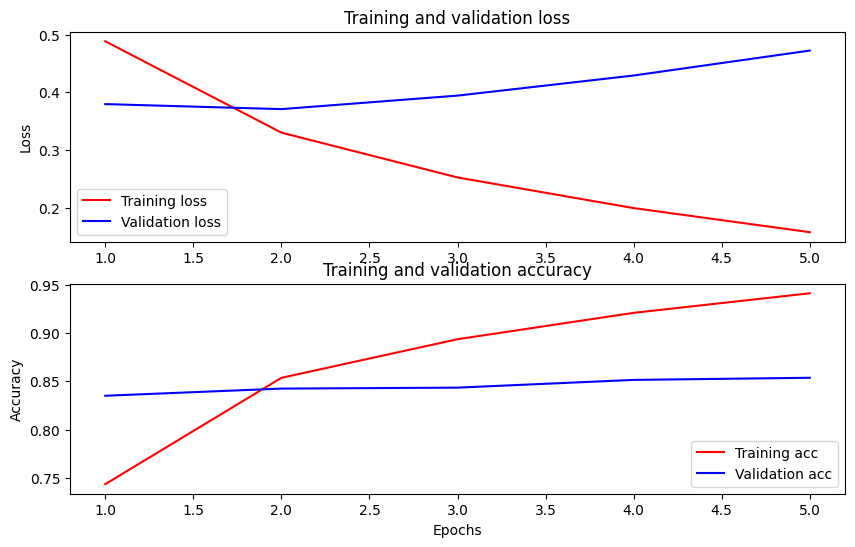

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Export for inference

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724



In [ ]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.997565
input: The movie was great!           : score: 0.983252
input: The movie was meh.             : score: 0.986901
input: The movie was okish.           : score: 0.206568
input: The movie was terrible...      : score: 0.001724

